# Exploratory Data Analysis & Machine Learning Working Code
# _Factors affecting vessel delays at US Army Corps of Engineers-managed locks on US waterways._

## Springboard Data Science Career Track, Capstone 2
***
* Author: Heather A. Passmore
* Data: United States Army Corps of Engineers, Lock Performance Management System
* Capstone Description: [Project Proposal](https://github.com/PassMoreHeat/springboard/blob/master/Capstone_2/ProjectProposalCap2.md)
* Initial Data Approach: [Data Wrangling Report](https://github.com/PassMoreHeat/springboard/blob/master/Capstone_2/Data_Wrangling_Report.md)
* Milestone Report: [Predicting Vessel Delays for Corps of Engineers-Lock Performance Management System (LPMS) Data](https://github.com/PassMoreHeat/springboard/blob/master/Capstone_2/LPMS_Milestone_Report.md)
* Final Report: [Predicting Vessel Delays](https://github.com/PassMoreHeat/springboard/blob/master/Capstone_2/LPMS_Final_Report.md)
***
## Table of Contents
1. Import Modules & Dataframes
2. Explore Machine Learning Data for 10 Focal Locks
3. Explore Lock data with histograms, boxplots, scatterplots, and t-tests

## 1. Import Modules & Dataframes

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
import pickle
import scipy.stats
from scipy.stats import norm
import scipy as sp

# Figures inline, visualization style
%matplotlib inline

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("talk")

In [3]:
# Bring ML_LPMS_final dataframe into workspace
# load the pickled ML_LPMS_final DataFrame from hard drive in 'rb' mode
with open('/Users/pgagnon/Documents/Springboard/springboard/Capstone_2/LockData/ML_LPMS_final.pickle','rb') as f:
    ML = pickle.load(f)

In [4]:
# Check ML contents and data types
ML.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15538 entries, 0 to 15537
Data columns (total 27 columns):
E_R_L                   15538 non-null object
YYMMDD                  15538 non-null datetime64[ns]
delay_cat               15538 non-null int64
LOCKAGE_TYPE            15538 non-null object
VESSEL_FUNCTION_TYPE    15538 non-null object
assist                  15538 non-null int64
year                    15538 non-null int64
day_of_year             15538 non-null int64
day_of_week             15538 non-null int64
month                   15538 non-null int64
hour_of_day             15538 non-null int64
entry_time              15538 non-null float64
exit_time               15538 non-null float64
delay_time              15538 non-null float64
unplan_max_stop         15538 non-null float64
AWND                    15538 non-null float64
PGTM                    15538 non-null float64
PRCP                    15538 non-null float64
SNOW                    15538 non-null float64
SNWD    

## 2. Explore Machine Learning Data for 10 Focal Locks

In [5]:
# Explore data for 10 focal locks
ML.E_R_L.value_counts()

B2_GI_77    1770
B2_FB_41    1763
M3_GI_11    1726
M3_GI_12    1710
B3_MI_27    1660
H2_OH_76    1641
B2_GI_4     1614
M3_GI_14    1571
G3_WS_1     1248
B2_GI_3      835
Name: E_R_L, dtype: int64

In [6]:
ML.LOCKAGE_TYPE.value_counts()

S    9349
O    6070
C      53
K      47
N       9
B       5
V       3
T       1
A       1
Name: LOCKAGE_TYPE, dtype: int64

In [7]:
#Define a generic function using Pandas replace function
def coding(col, codeDict):
  colCoded = pd.Series(col, copy=True)
  for key, value in codeDict.items():
    colCoded.replace(key, value, inplace=True)
  return colCoded

In [8]:
# Lump the rare and barge-related lockage types (A, B, T, V) into one category (X)
#Coding LOCKAGE_TYPE (A, B, T, V) as X:
print('Before Coding:')
print(pd.value_counts(ML['LOCKAGE_TYPE']))
ML['lockage'] = coding(ML['LOCKAGE_TYPE'], {'A':'X','B':'X','T':'X','V':'X'})
print('\nAfter Coding:')
print(pd.value_counts(ML['lockage']))

Before Coding:
S    9349
O    6070
C      53
K      47
N       9
B       5
V       3
T       1
A       1
Name: LOCKAGE_TYPE, dtype: int64

After Coding:
S    9349
O    6070
C      53
K      47
X      10
N       9
Name: lockage, dtype: int64


In [9]:
# Lump Dry Cargo (C) and Liquid Cargo (E): Y
# Lump Federal Gov. Ves (G), Government Nonfederal Ves (N), and Fed. Gov Contractor (U): X
# Lump Non-Cargo Vessel (M) with Other (Z): W
#Coding VESSEL_FUNCTION_TYPE (A, B, T, V) as X:
print('Before Coding:')
print(pd.value_counts(ML['VESSEL_FUNCTION_TYPE']))
ML['VFT'] = coding(ML['VESSEL_FUNCTION_TYPE'], {'C':'Y','E':'Y','G':'X','N':'X','U':'X','M':'W','Z':'W'})
print('\nAfter Coding:')
print(pd.value_counts(ML['VFT']))

Before Coding:
T    12657
R      870
K      702
C      592
F      441
P      159
G       50
N       30
Z       15
E       14
M        5
U        3
Name: VESSEL_FUNCTION_TYPE, dtype: int64

After Coding:
T    12657
R      870
K      702
Y      606
F      441
P      159
X       83
W       20
Name: VFT, dtype: int64


In [10]:
# Encode all TIME variables. First: day_of_week (Monday=0, Sunday = 6) => weekday(1)/weekend(0) 
#Coding weekday where weekdays (0-4) = 1, weekend (5, 6) = 0
print('Before Coding:')
print(pd.value_counts(ML['day_of_week']))
ML['weekday'] = coding(ML['day_of_week'], {0:1,1:1,2:1,3:1,4:1,5:0,6:0})
print('\nAfter Coding:')
print(pd.value_counts(ML['weekday']))

Before Coding:
5    2433
6    2427
2    2220
1    2170
4    2135
3    2127
0    2026
Name: day_of_week, dtype: int64

After Coding:
1    10678
0     4860
Name: weekday, dtype: int64


In [11]:
# Encode all TIME variables. Next: month (1-12) to season (spring, summer, fall, winter)
#Coding season where spring (month 0-4) = 1, weekend (5, 6) = 0
print('Before Coding:')
print(pd.value_counts(ML['month']))
ML['season'] = coding(ML['month'], {1:'winter',2:'winter',3:'spring',4:'spring',5:'spring',6:'summer',
                                    7:'summer',8:'summer',9:'fall',10:'fall',11:'fall',12:'winter'})
print('\nAfter Coding:')
print(pd.value_counts(ML['season']))

Before Coding:
1     1347
10    1339
7     1337
8     1327
3     1323
5     1317
11    1302
12    1293
4     1264
6     1251
9     1250
2     1188
Name: month, dtype: int64

After Coding:
summer    3915
spring    3904
fall      3891
winter    3828
Name: season, dtype: int64


In [12]:
# Identify US holidays over the 5-year period (True/False)
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
dr = pd.date_range(start='2013-01-01', end='2017-12-31')

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

ML['holiday'] = ML['YYMMDD'].isin(holidays)
ML.holiday.value_counts()

False    15080
True       458
Name: holiday, dtype: int64

In [13]:
# Log transform 'delay_time' to constrain spread
ML = ML.assign(log_delay = lambda x: np.log(x.delay_time + 1))

In [14]:
# Log transform 'unplan_max_stop' to constrain spread
ML = ML.assign(log_unplan = lambda x: np.log(x.unplan_max_stop + 1))

## 3. Explore Lock data with histograms, boxplots, scatterplots, and t-tests

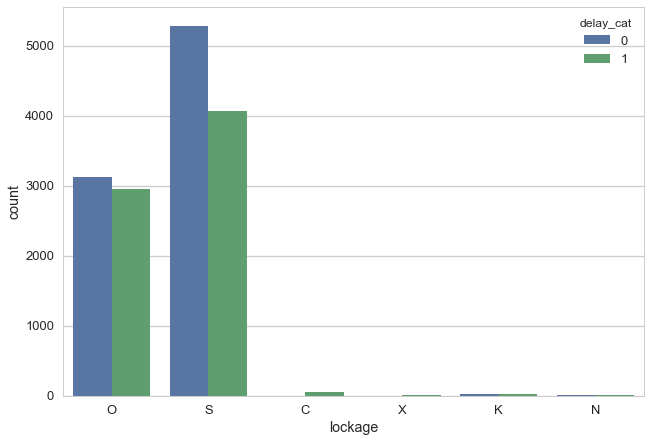

In [15]:
# Plot 'delay_cat' by 'LOCKAGE_TYPE' with Seaborn countplot
sns.countplot(x='lockage', data=ML, hue='delay_cat');

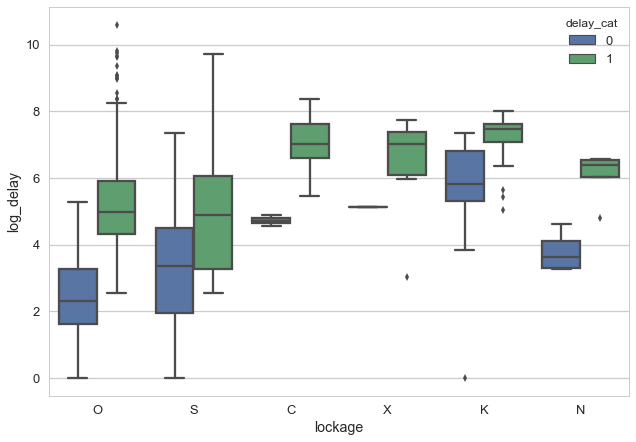

In [16]:
# Plot 'delay_cat' by 'LOCKAGE_TYPE' with Seaborn countplot
sns.boxplot(x='lockage', y="log_delay", data=ML, hue='delay_cat');

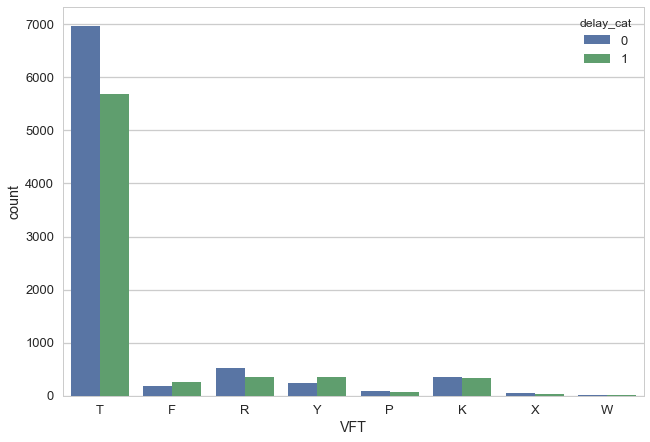

In [17]:
# Use countplot to see delay_time with delay_cat and VESSEL_FUNCTION_TYPE
sns.countplot(x="VFT", hue="delay_cat", data=ML);

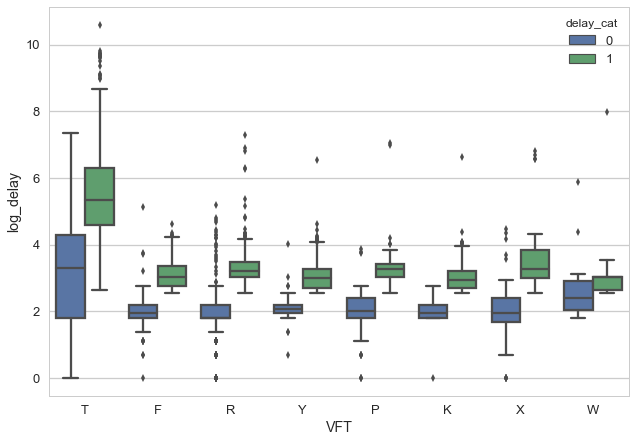

In [18]:
# Use boxplot to see delay_time with delay_cat and VESSEL_FUNCTION_TYPE
sns.boxplot(x="VFT", y="log_delay", hue="delay_cat", data=ML);

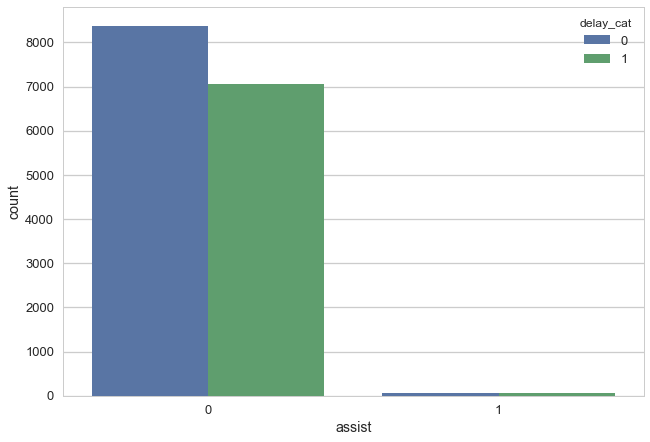

In [19]:
# Use countplot to see assist (0=no assist) with delay_cat
sns.countplot(x="assist", hue="delay_cat", data=ML);

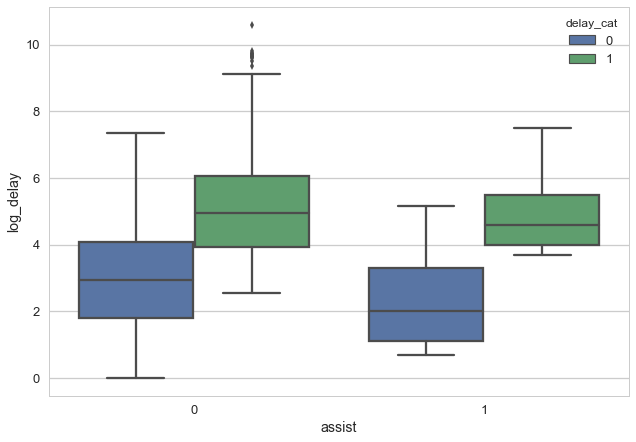

In [20]:
# Use boxplot to see log_delay with delay_cat for assist where 1= True, 0= False (no assist)
sns.boxplot(x="assist", y="log_delay", hue="delay_cat", data=ML);

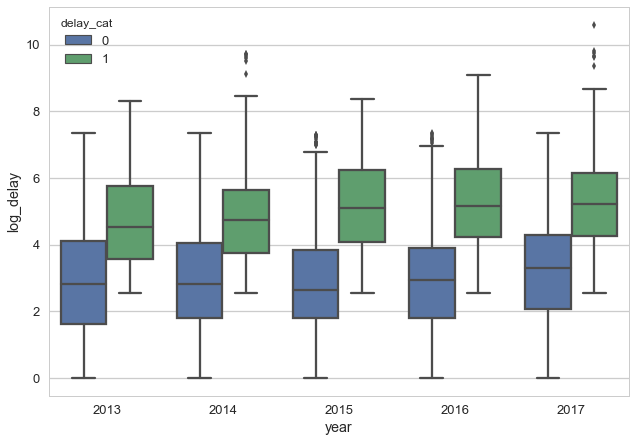

In [21]:
# Use boxplot to see year and log_delay with delay_cat
sns.boxplot(x="year", y="log_delay", hue="delay_cat", data=ML);

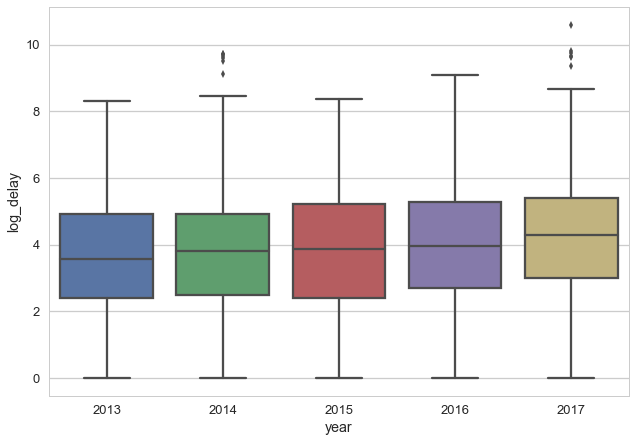

In [22]:
# Use boxplot to see year and log_delay overall
sns.boxplot(x="year", y="log_delay",  data=ML);

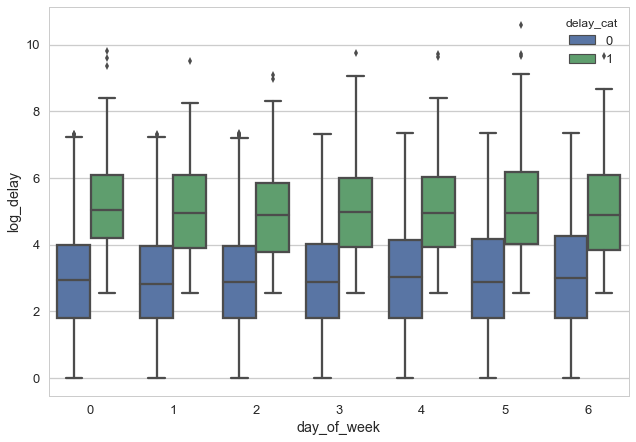

In [23]:
# Use boxplot to see delay_time with delay_cat
sns.boxplot(x="day_of_week", y="log_delay", hue="delay_cat", data=ML);

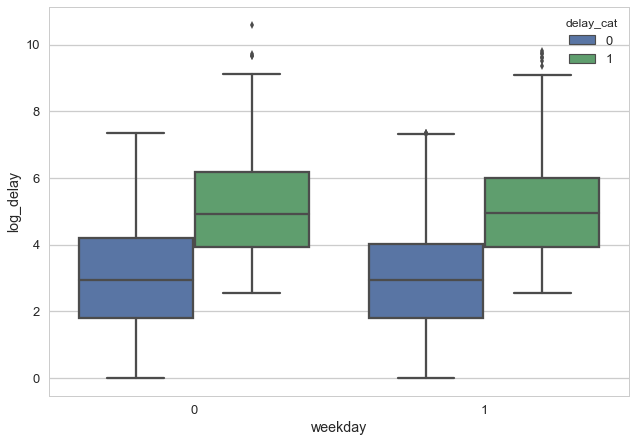

In [24]:
# Use boxplot to see weekday and delay_time with delay_cat (weekdays=1, weekend=0)
sns.boxplot(x="weekday", y="log_delay", hue="delay_cat", data=ML);

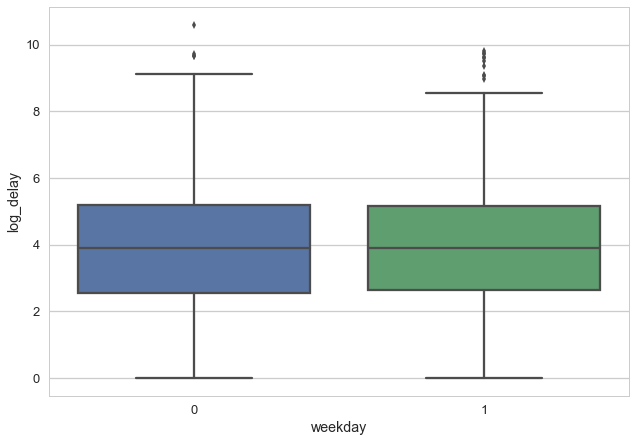

In [25]:
# Use boxplot to see weekday and delay_time with delay_cat (weekdays=1, weekend=0)
sns.boxplot(x="weekday", y="log_delay", data=ML);

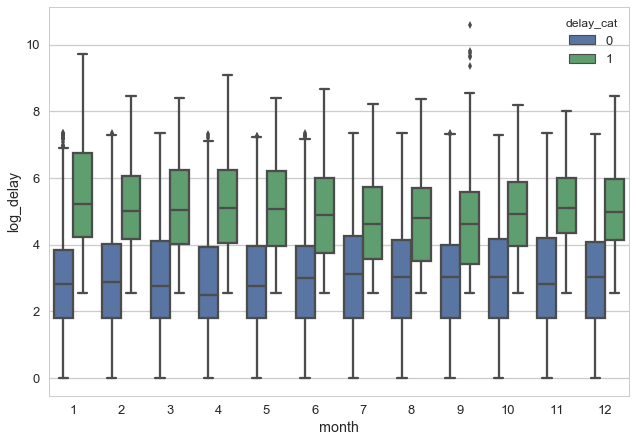

In [26]:
# Use boxplot to see month and delay_time with delay_cat
sns.boxplot(x="month", y="log_delay", hue="delay_cat", data=ML);

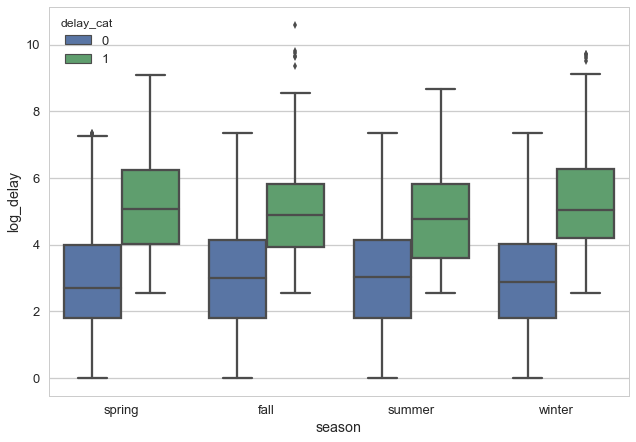

In [27]:
# Use boxplot to see season and delay_time with delay_cat
sns.boxplot(x="season", y="log_delay", hue="delay_cat", data=ML); # adjust order of seasons

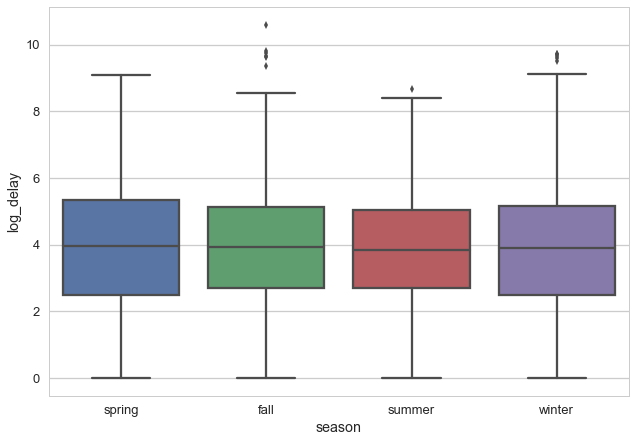

In [28]:
# Use boxplot to see season and delay_time with delay_cat
sns.boxplot(x="season", y="log_delay", data=ML);

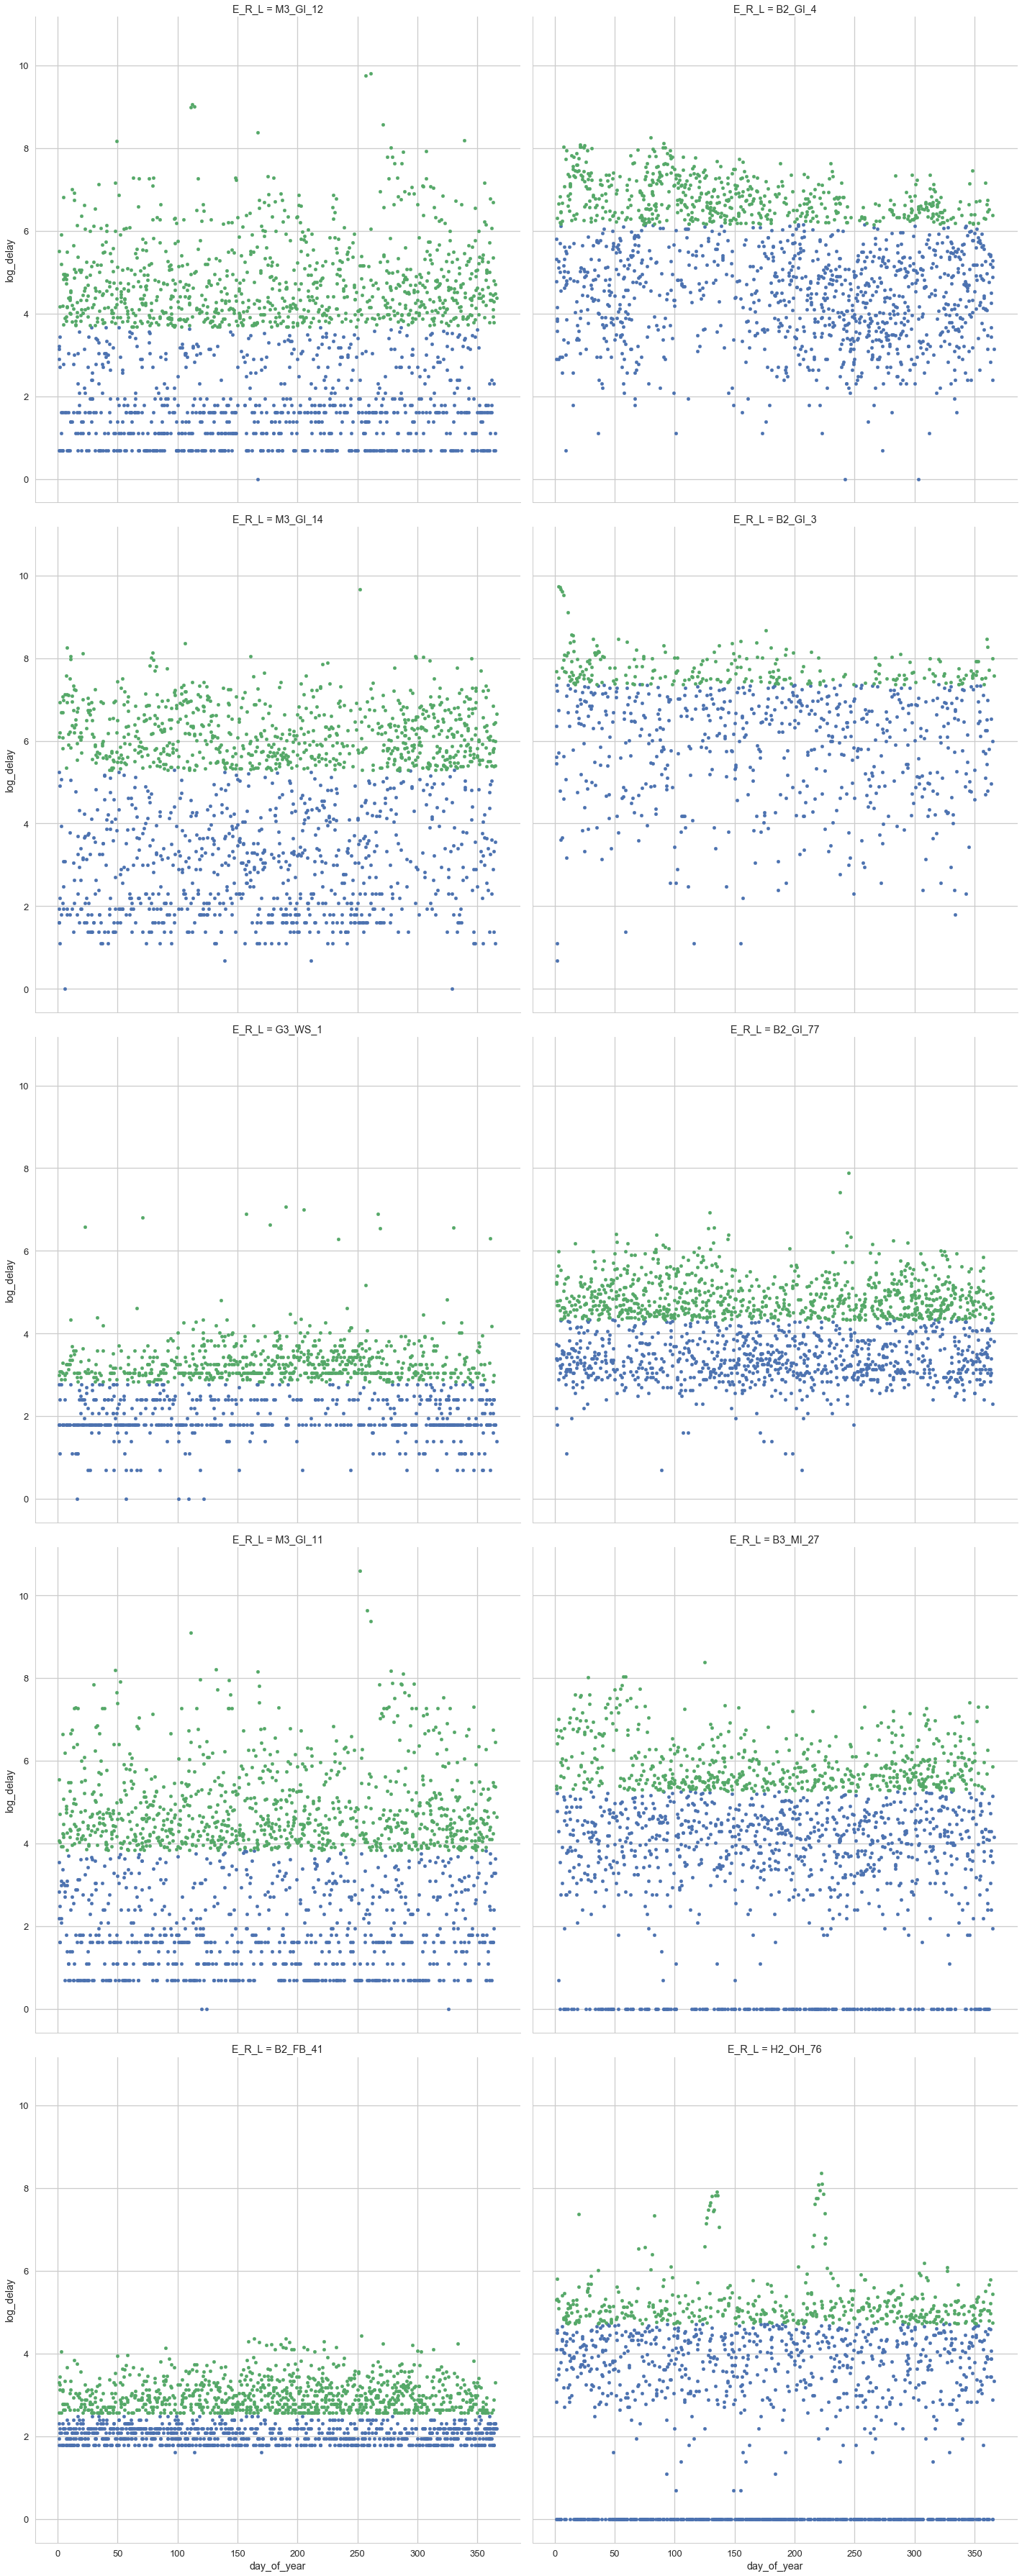

In [29]:
# scatterplot with log_delay and day_of_year
g = sns.FacetGrid(ML, col="E_R_L", col_wrap=2, size=10, hue="delay_cat")
g = g.map(plt.scatter, "day_of_year", "log_delay", marker=".")

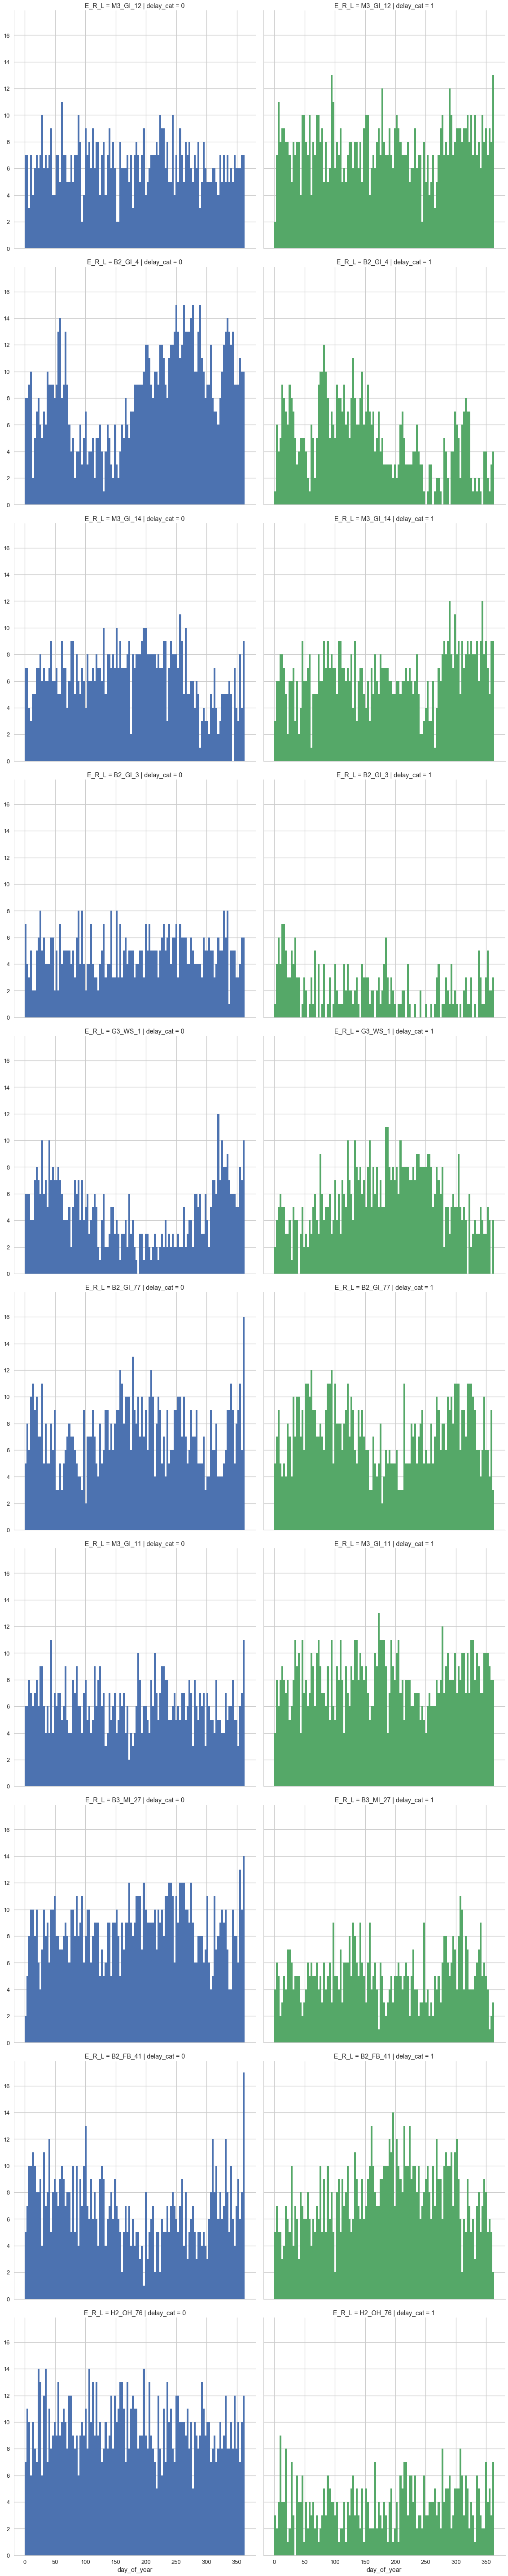

In [31]:
# countplot with day_of_year binned in threes, rows are locks
bins = np.arange(0, 366, 3)
g = sns.FacetGrid(ML, col="delay_cat",  row="E_R_L", size = 8, hue='delay_cat')
g = g.map(plt.hist, "day_of_year", bins=bins)

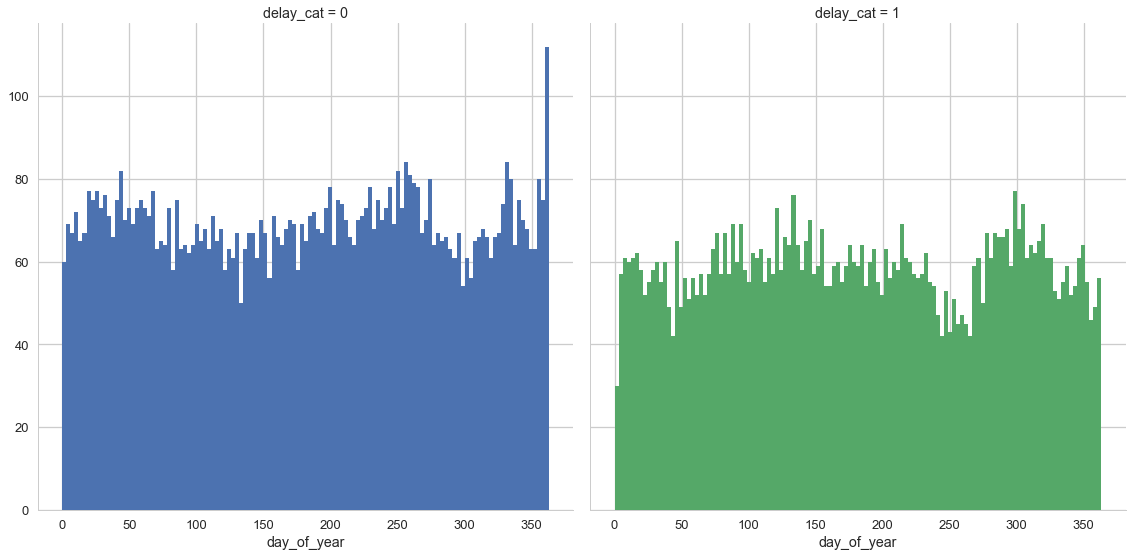

In [32]:
# countplot with day_of_year binned in threes
bins = np.arange(0, 366, 3)
g = sns.FacetGrid(ML, col="delay_cat", size = 8, hue='delay_cat')
g = g.map(plt.hist, "day_of_year", bins=bins)

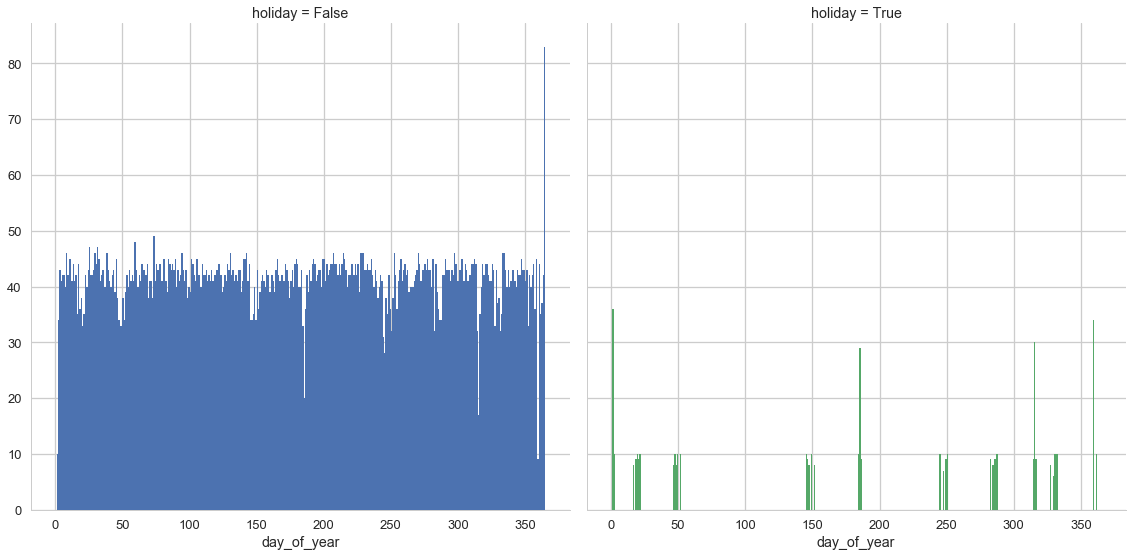

In [33]:
# countplot with day_of_year binned in ones with holiday as hue
bins = np.arange(0, 366, 1)
g = sns.FacetGrid(ML, col="holiday", size = 8, hue='holiday')
g = g.map(plt.hist, "day_of_year", bins=bins)

In [34]:
ML.day_of_year.mode()

0     73
1    185
dtype: int64

In [35]:
scipy.stats.mode(ML.day_of_year)

ModeResult(mode=array([73]), count=array([49]))

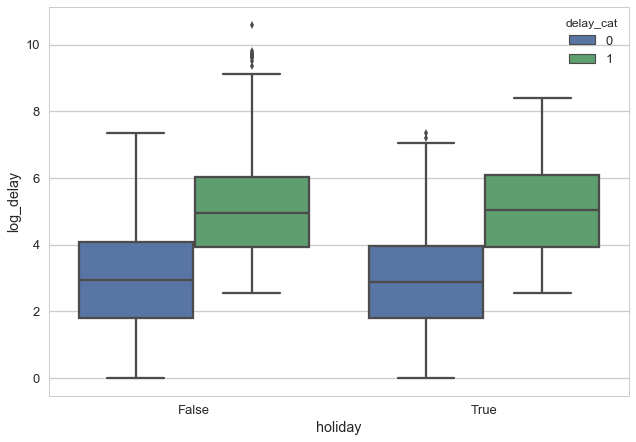

In [36]:
# Plot 'delay_cat' by 'holiday' with Seaborn boxplot
sns.boxplot(x='holiday', y="log_delay", data=ML, hue='delay_cat');

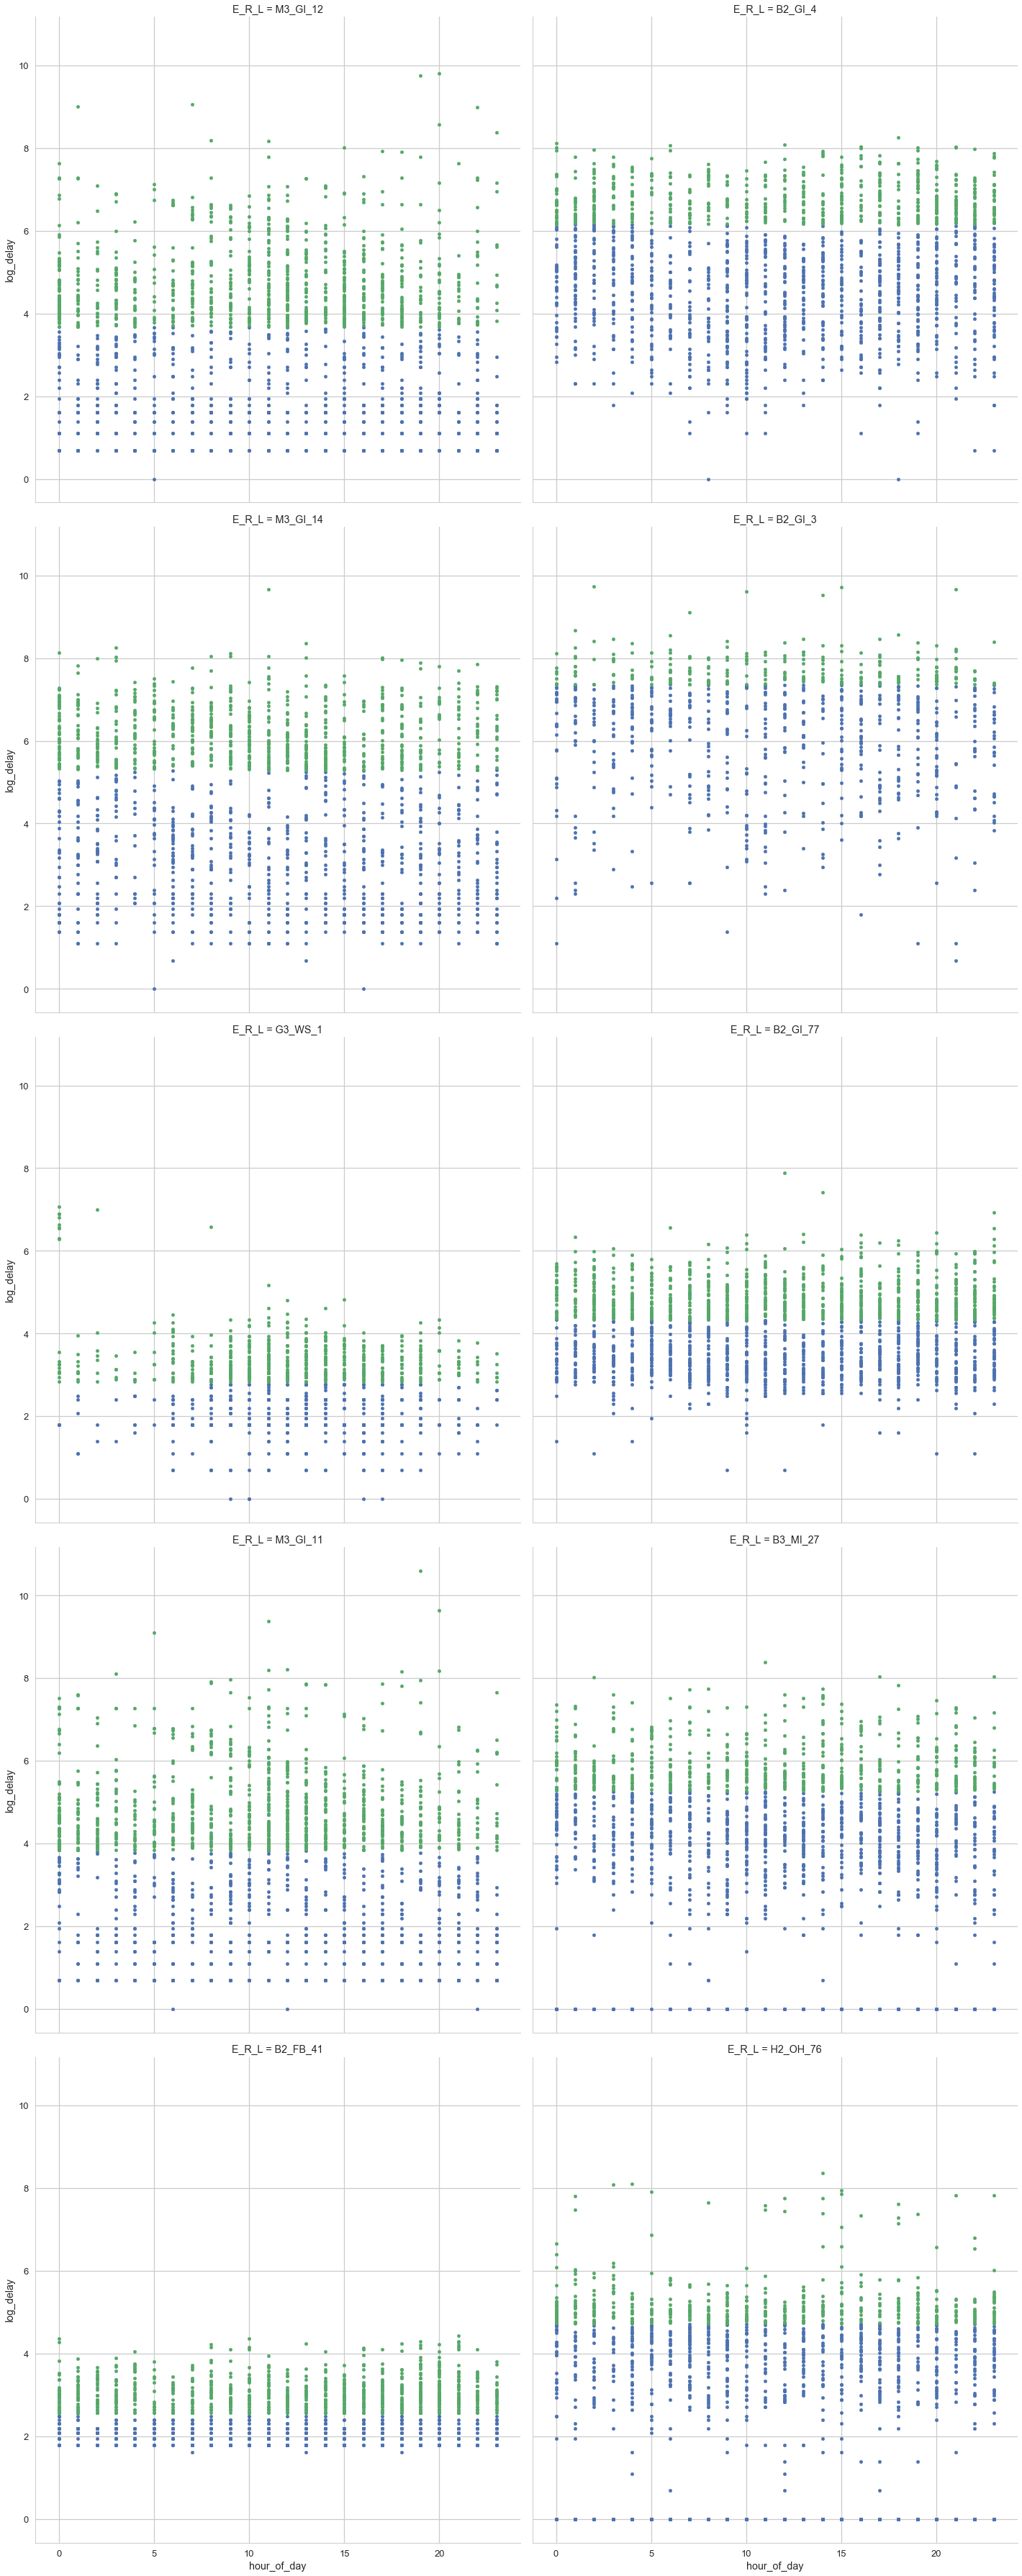

In [37]:
# countplot with log_delay and day_of_year
g = sns.FacetGrid(ML, col="E_R_L", col_wrap=2, size=10, hue="delay_cat")
g = g.map(plt.scatter, "hour_of_day", "log_delay", marker=".")

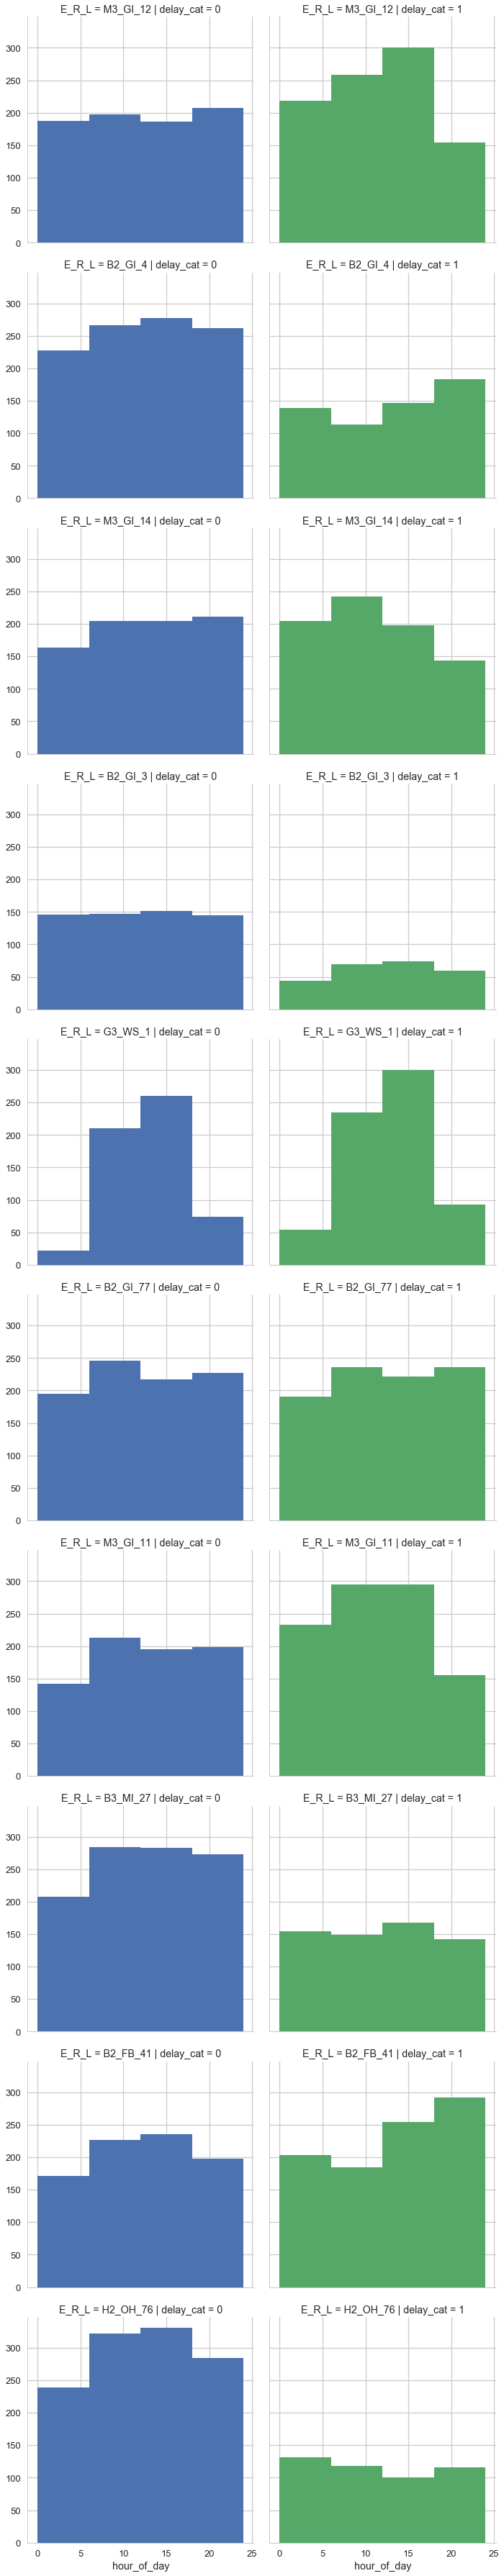

In [38]:
bins = np.arange(0, 30, 6)
g = sns.FacetGrid(ML, col="delay_cat",  row="E_R_L", size = 5, hue='delay_cat')
g = g.map(plt.hist, "hour_of_day", bins=bins)

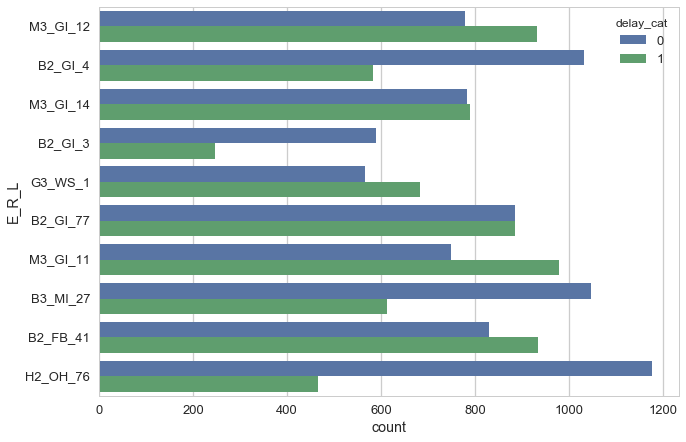

In [39]:
# Use boxplot to see delay_time with delay_cat
sns.countplot(y="E_R_L", hue="delay_cat", data=ML);

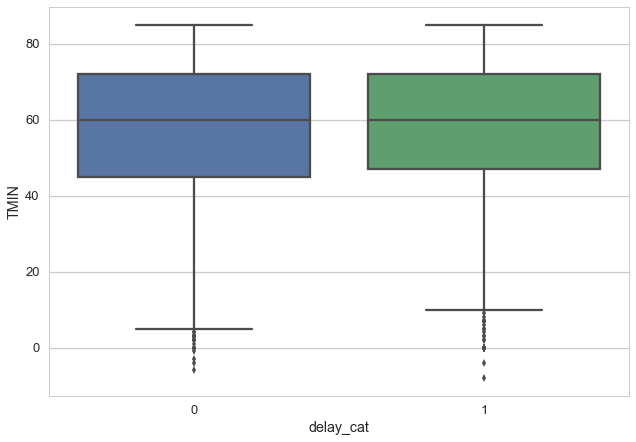

In [40]:
# Use boxplot to see minimum temperatures (TMIN) with delay_cat
sns.boxplot(x="delay_cat", y="TMIN",  data=ML);

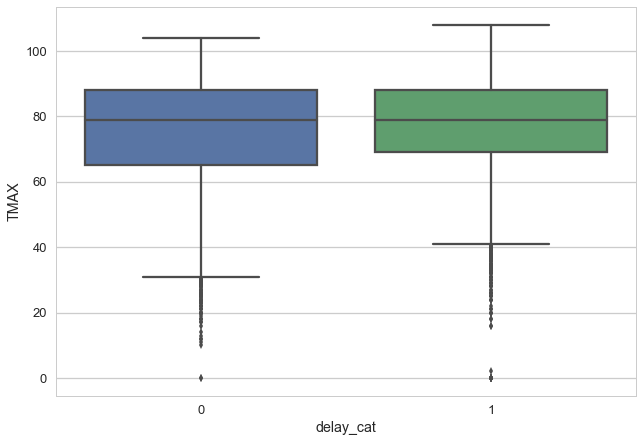

In [41]:
# Use boxplot to see maximum temperatures (TMAX) with delay_cat
sns.boxplot(x="delay_cat", y="TMAX",  data=ML);

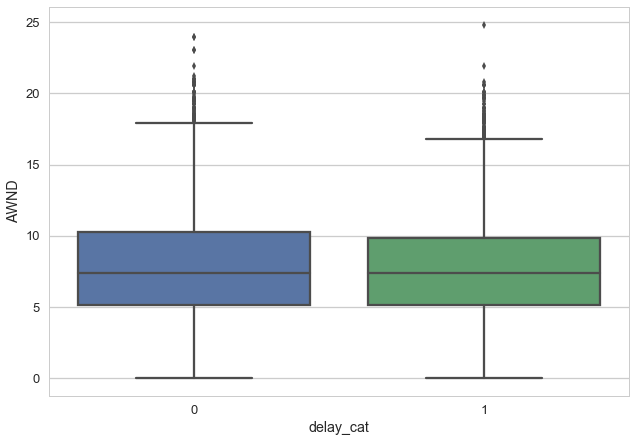

In [42]:
# Use boxplot to see average wind speed (AWND) with delay_cat
sns.boxplot(x="delay_cat", y="AWND",  data=ML);

In [43]:
# Make a list of numerical columns and replace zeros with NaN for scatter plots, etc.
ML_tmp = ML.drop(['LOCKAGE_TYPE', 'VESSEL_FUNCTION_TYPE'], axis=1)
num_vars = ['log_delay','unplan_max_stop', 'AWND', 'PGTM', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 
          'TMAX', 'TMIN', 'WSF2', 'WSF5', 'WT_count']
ML_tmp[num_vars] = ML_tmp[num_vars].replace({0:np.nan})

ML_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15538 entries, 0 to 15537
Data columns (total 32 columns):
E_R_L              15538 non-null object
YYMMDD             15538 non-null datetime64[ns]
delay_cat          15538 non-null int64
assist             15538 non-null int64
year               15538 non-null int64
day_of_year        15538 non-null int64
day_of_week        15538 non-null int64
month              15538 non-null int64
hour_of_day        15538 non-null int64
entry_time         15538 non-null float64
exit_time          15538 non-null float64
delay_time         15538 non-null float64
unplan_max_stop    854 non-null float64
AWND               15513 non-null float64
PGTM               128 non-null float64
PRCP               4834 non-null float64
SNOW               103 non-null float64
SNWD               116 non-null float64
TAVG               6602 non-null float64
TMAX               15526 non-null float64
TMIN               15519 non-null float64
WSF2               15521 no

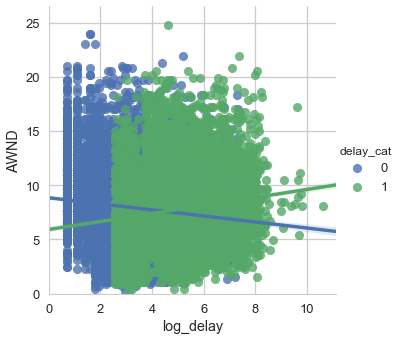

In [44]:
# scatter with log_delay and average wind speed
sns.lmplot(x="log_delay", y="AWND", hue="delay_cat", data=ML_tmp);
plt.ylim(0, None);
plt.xlim(0, None);

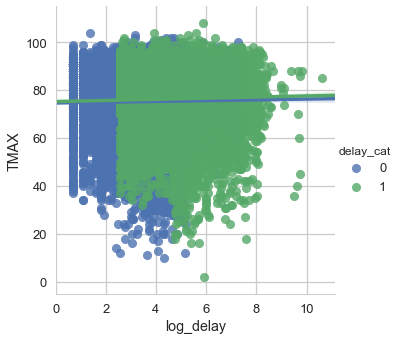

In [45]:
# scatter with log_delay and maximum temperature
sns.lmplot(x="log_delay", y="TMAX", hue="delay_cat", data=ML_tmp);

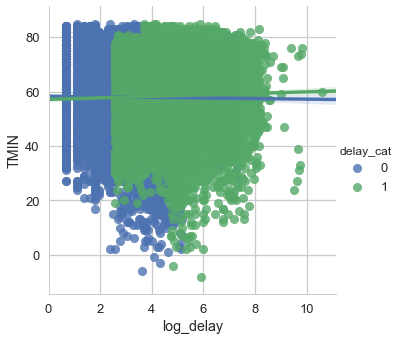

In [46]:
# scatter with log_delay and maximum temperature
sns.lmplot(x="log_delay", y="TMIN", hue="delay_cat", data=ML_tmp);

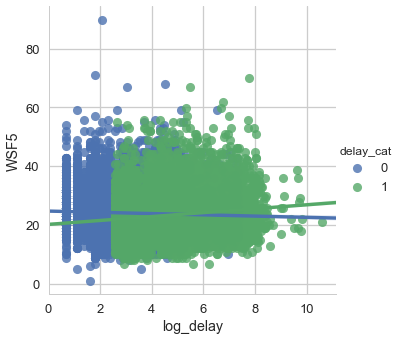

In [47]:
# scatter with log_delay and Fastest 5-second wind speed
sns.lmplot(x="log_delay", y="WSF5", hue="delay_cat", data=ML_tmp);

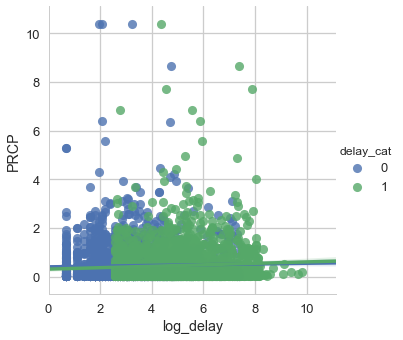

In [48]:
# scatter with log_delay and precipitation
sns.lmplot(x="log_delay", y="PRCP", hue="delay_cat", data=ML_tmp);

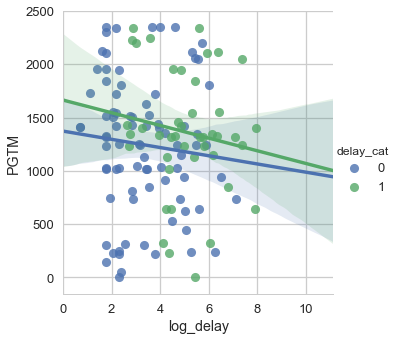

In [49]:
# scatter with log_delay and Peak gust time
sns.lmplot(x="log_delay", y="PGTM", hue="delay_cat", data=ML_tmp);

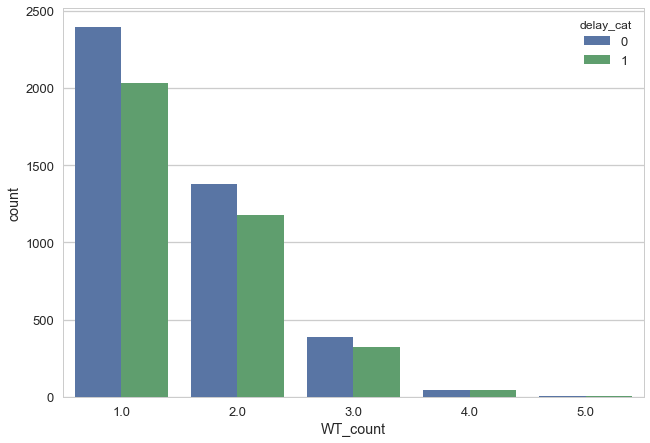

In [50]:
# countplot with count of recorded weather types
sns.countplot(x="WT_count", hue='delay_cat', data=ML_tmp);

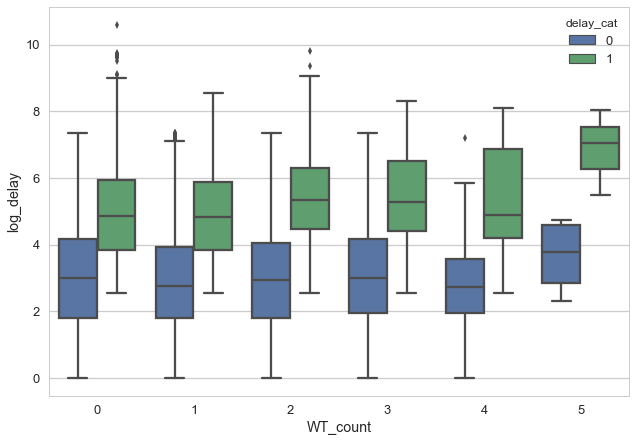

In [51]:
# Use boxplot to see count of weather types and delay_time with delay_cat
sns.boxplot(x="WT_count", y="log_delay", hue="delay_cat", data=ML);

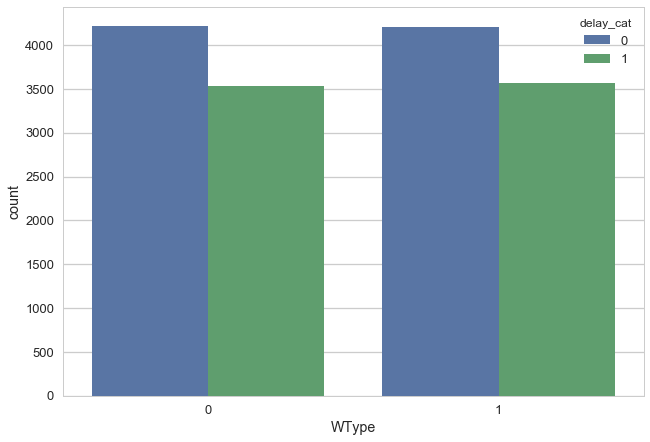

In [52]:
# countplot with count of recorded weather types
sns.countplot(x="WType", hue='delay_cat', data=ML);

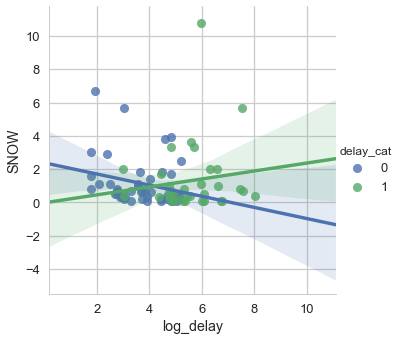

In [53]:
# scatter with log_delay and snowfall
sns.lmplot(x="log_delay", y="SNOW", hue="delay_cat", data=ML_tmp);

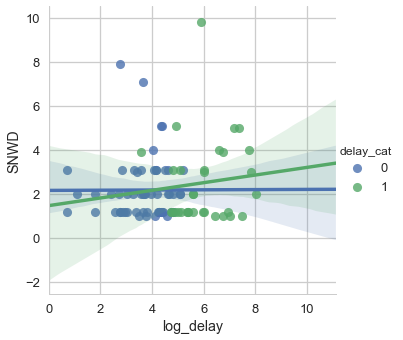

In [54]:
# scatter with log_delay and snow depth
sns.lmplot(x="log_delay", y="SNWD", hue="delay_cat", data=ML_tmp);

In [55]:
# create arrays for t-test of min_temp and delay_cat
temp_delay = ML.TMIN[ML.delay_cat == 1]
temp_not = ML.TMIN[ML.delay_cat == 0]

In [56]:
temp_delay.describe()

count    7103.000000
mean       58.422216
std        15.266001
min        -8.000000
25%        47.000000
50%        60.000000
75%        72.000000
max        85.000000
Name: TMIN, dtype: float64

In [57]:
temp_not.describe()

count    8435.000000
mean       57.258091
std        16.716906
min        -6.000000
25%        45.000000
50%        60.000000
75%        72.000000
max        85.000000
Name: TMIN, dtype: float64

In [58]:
# perform hypothesis test with two-sided independent t-test for equal variances
tstat, p_value = scipy.stats.ttest_ind(temp_not, temp_delay, equal_var=True)
print('Tests statistic', '{0:0.3f}'.format(tstat))
print('P-value of test', '{0:0.3f}'.format(p_value))
if p_value < 0.05:
    print('Reject the Null hypothesis: There is a difference between minimum daily temperature for delay vs not delayed.')
else:
    print('Fail to reject the Null: There is no difference between minimum daily temperature for delay categories.')

Tests statistic -4.498
P-value of test 0.000
Reject the Null hypothesis: There is a difference between minimum daily temperature for delay vs not delayed.


In [59]:
# create arrays for t-test of average wind speed and delay_cat
wind_delay = ML.AWND[ML.delay_cat == 1]
wind_not = ML.AWND[ML.delay_cat == 0]

In [60]:
wind_delay.describe()

count    7103.000000
mean        7.758685
std         3.579570
min         0.000000
25%         5.140000
50%         7.380000
75%         9.840000
max        24.830000
Name: AWND, dtype: float64

In [61]:
wind_not.describe()

count    8435.000000
mean        7.877608
std         3.707937
min         0.000000
25%         5.140000
50%         7.380000
75%        10.290000
max        23.940000
Name: AWND, dtype: float64

In [62]:
# perform hypothesis test with two-sided independent t-test for equal variances
tstat, p_value = scipy.stats.ttest_ind(wind_not, wind_delay, equal_var=True)
print('Tests statistic', '{0:0.3f}'.format(tstat))
print('P-value of test', '{0:0.3f}'.format(p_value))
if p_value < 0.05:
    print('Reject the Null hypothesis: There is a difference between average daily wind speed for delay vs not delayed.')
else:
    print('Fail to reject the Null: There is no difference between average wind speed for delay categories.')

Tests statistic 2.023
P-value of test 0.043
Reject the Null hypothesis: There is a difference between average daily wind speed for delay vs not delayed.


In [63]:
# create arrays for t-test of snow and delay_cat
snow_delay = ML.SNOW[ML.delay_cat == 1]
snow_not = ML.SNOW[ML.delay_cat == 0]

In [64]:
snow_delay.describe()

count    7103.00000
mean        0.00642
std         0.17024
min         0.00000
25%         0.00000
50%         0.00000
75%         0.00000
max        10.80000
Name: SNOW, dtype: float64

In [65]:
snow_not.describe()

count    8435.000000
mean        0.010279
std         0.183341
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         8.500000
Name: SNOW, dtype: float64

In [66]:
# perform hypothesis test with two-sided independent t-test for equal variances
tstat, p_value = scipy.stats.ttest_ind(snow_not, snow_delay, equal_var=True)
print('Tests statistic', '{0:0.3f}'.format(tstat))
print('P-value of test', '{0:0.3f}'.format(p_value))
if p_value < 0.05:
    print('Reject the Null hypothesis: There is a difference between daily snowfall for delay vs not delayed.')
else:
    print('Fail to reject the Null: There is no difference between snow amount for delay categories.')

Tests statistic 1.350
P-value of test 0.177
Fail to reject the Null: There is no difference between snow amount for delay categories.
